In [10]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [11]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=LTC&tsym=USD&limit=2000')
df = pd.DataFrame(json.loads(res.content)['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
target_col='close'

In [12]:
df

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2016-05-02,3.777,3.612,3.698,150952.67,5.575085e+05,3.673,direct,
2016-05-03,3.773,3.632,3.673,158772.71,5.897153e+05,3.729,direct,
2016-05-04,3.783,3.703,3.729,50044.94,1.869948e+05,3.733,direct,
2016-05-05,3.764,3.678,3.733,61195.85,2.280908e+05,3.698,direct,
2016-05-06,3.796,3.689,3.698,69061.29,2.593226e+05,3.781,direct,
...,...,...,...,...,...,...,...,...
2021-10-19,191.580,183.330,185.620,467553.50,8.775800e+07,188.830,direct,
2021-10-20,209.310,185.810,188.830,834042.91,1.661293e+08,207.320,direct,
2021-10-21,214.540,195.410,207.320,930858.01,1.905464e+08,196.890,direct,


In [13]:
df = df.drop(['conversionType','conversionSymbol'], axis=1)
df

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2016-05-02,3.777,3.612,3.698,150952.67,5.575085e+05,3.673
2016-05-03,3.773,3.632,3.673,158772.71,5.897153e+05,3.729
2016-05-04,3.783,3.703,3.729,50044.94,1.869948e+05,3.733
2016-05-05,3.764,3.678,3.733,61195.85,2.280908e+05,3.698
2016-05-06,3.796,3.689,3.698,69061.29,2.593226e+05,3.781
...,...,...,...,...,...,...
2021-10-19,191.580,183.330,185.620,467553.50,8.775800e+07,188.830
2021-10-20,209.310,185.810,188.830,834042.91,1.661293e+08,207.320
2021-10-21,214.540,195.410,207.320,930858.01,1.905464e+08,196.890


In [14]:

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [16]:
def train_test_split(df, test_size=0.4):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [17]:
train, test = train_test_split(df,test_size=0.4)

In [19]:
np.array(train)
np.array(test)

array([[7.91300000e+01, 7.41500000e+01, 7.63000000e+01, 2.94820087e+06,
        2.20654398e+08, 7.48400000e+01],
       [7.44500000e+01, 7.18300000e+01, 7.48400000e+01, 2.58769223e+06,
        1.88152177e+08, 7.27100000e+01],
       [7.76900000e+01, 7.30100000e+01, 7.27100000e+01, 2.40629918e+06,
        1.83900395e+08, 7.64200000e+01],
       ...,
       [2.14540000e+02, 1.95410000e+02, 2.07320000e+02, 9.30858010e+05,
        1.90546381e+08, 1.96890000e+02],
       [2.01400000e+02, 1.87910000e+02, 1.96890000e+02, 6.67102380e+05,
        1.30632811e+08, 1.90950000e+02],
       [1.97820000e+02, 1.89050000e+02, 1.90950000e+02, 2.32800510e+05,
        4.49623054e+07, 1.97230000e+02]])

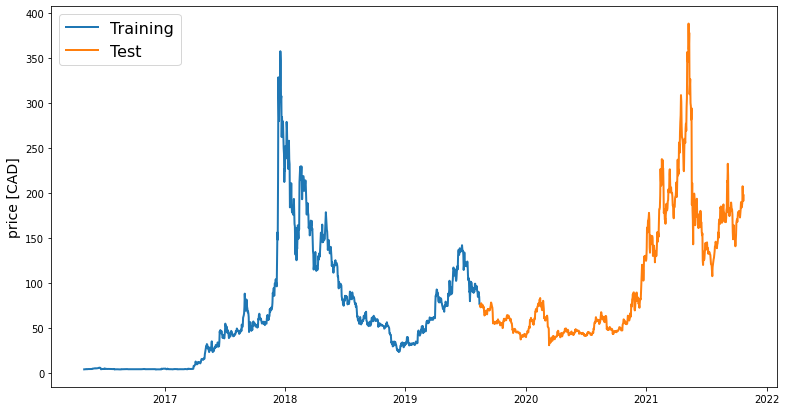

In [20]:
line_plot(train[target_col], test[target_col], 'Training', 'Test', title='')

In [21]:
print(train)
print(test)

              high     low    open  volumefrom      volumeto   close
time                                                                
2016-05-02   3.777   3.612   3.698   150952.67  5.575085e+05   3.673
2016-05-03   3.773   3.632   3.673   158772.71  5.897153e+05   3.729
2016-05-04   3.783   3.703   3.729    50044.94  1.869948e+05   3.733
2016-05-05   3.764   3.678   3.733    61195.85  2.280908e+05   3.698
2016-05-06   3.796   3.689   3.698    69061.29  2.593226e+05   3.781
...            ...     ...     ...         ...           ...     ...
2019-08-11  92.790  87.170  85.320  2762722.88  2.484587e+08  89.930
2019-08-12  88.800  85.250  89.930  2423962.14  2.077652e+08  85.710
2019-08-13  86.270  80.580  85.710  2994595.56  2.532953e+08  84.580
2019-08-14  81.370  74.130  84.580  3972842.05  3.009858e+08  75.760
2019-08-15  80.270  73.370  75.760  3579122.78  2.730999e+08  76.300

[1201 rows x 6 columns]
              high     low    open  volumefrom      volumeto   close
time     

In [22]:

def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [23]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [24]:

def prepare_data(df, target_col, window_len=5, zero_base=True, test_size=0.4):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [63]:

def build_lstm_model(input_data, output_size, neurons=150, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [64]:
np.random.seed(42)
window_len = 5
test_size = 0.4
zero_base = True
lstm_neurons = 150
epochs = 40
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [65]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [72]:
#Early stopping using callbacks
from keras.callbacks import EarlyStopping
es = EarlyStopping(mode='min',verbose=1,patience=4)

In [73]:
model = build_lstm_model( X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit( X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3, validation_data=(X_test,y_test), verbose=1, shuffle=True, callbacks=[es])

Epoch 1/40
27/27 [==============================] - 3s 28ms/step - loss: 0.0218 - val_loss: 0.0078
Epoch 2/40
27/27 [==============================] - 0s 13ms/step - loss: 0.0156 - val_loss: 0.0057
Epoch 3/40
27/27 [==============================] - 0s 12ms/step - loss: 0.0156 - val_loss: 0.0054
Epoch 4/40
27/27 [==============================] - 0s 12ms/step - loss: 0.0120 - val_loss: 0.0049
Epoch 5/40
27/27 [==============================] - 0s 12ms/step - loss: 0.0119 - val_loss: 0.0050
Epoch 6/40
27/27 [==============================] - 0s 12ms/step - loss: 0.0128 - val_loss: 0.0046
Epoch 7/40
27/27 [==============================] - 0s 12ms/step - loss: 0.0112 - val_loss: 0.0043
Epoch 8/40
27/27 [==============================] - 0s 12ms/step - loss: 0.0114 - val_loss: 0.0041
Epoch 9/40
27/27 [==============================] - 0s 12ms/step - loss: 0.0094 - val_loss: 0.0040
Epoch 10/40
27/27 [==============================] - 0s 12ms/step - loss: 0.0095 - val_loss: 0.0040
Epoch 11/

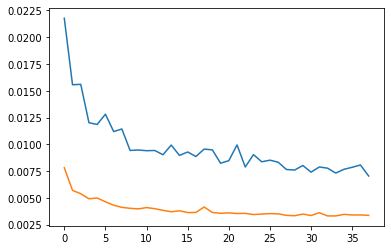

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [75]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.04014966043586966

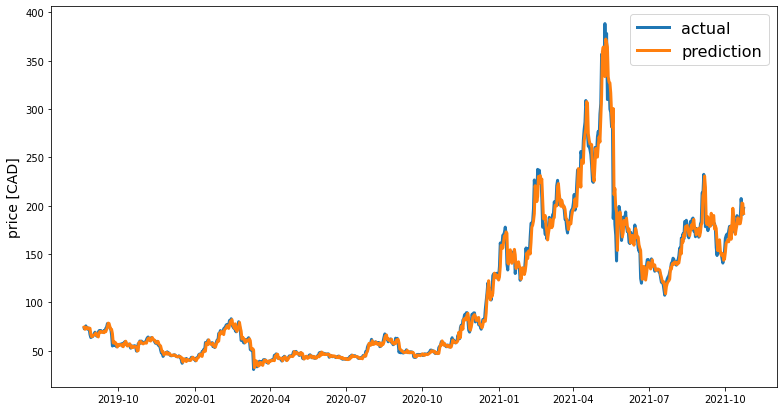

In [76]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [77]:
model.save('LTCmodel.hdf5')